# BERT

In this notebook we'll take a look at how we can use transformer models (like BERT) to create sentence vectors for calculating similarity. Let's start by defining a few example sentences.

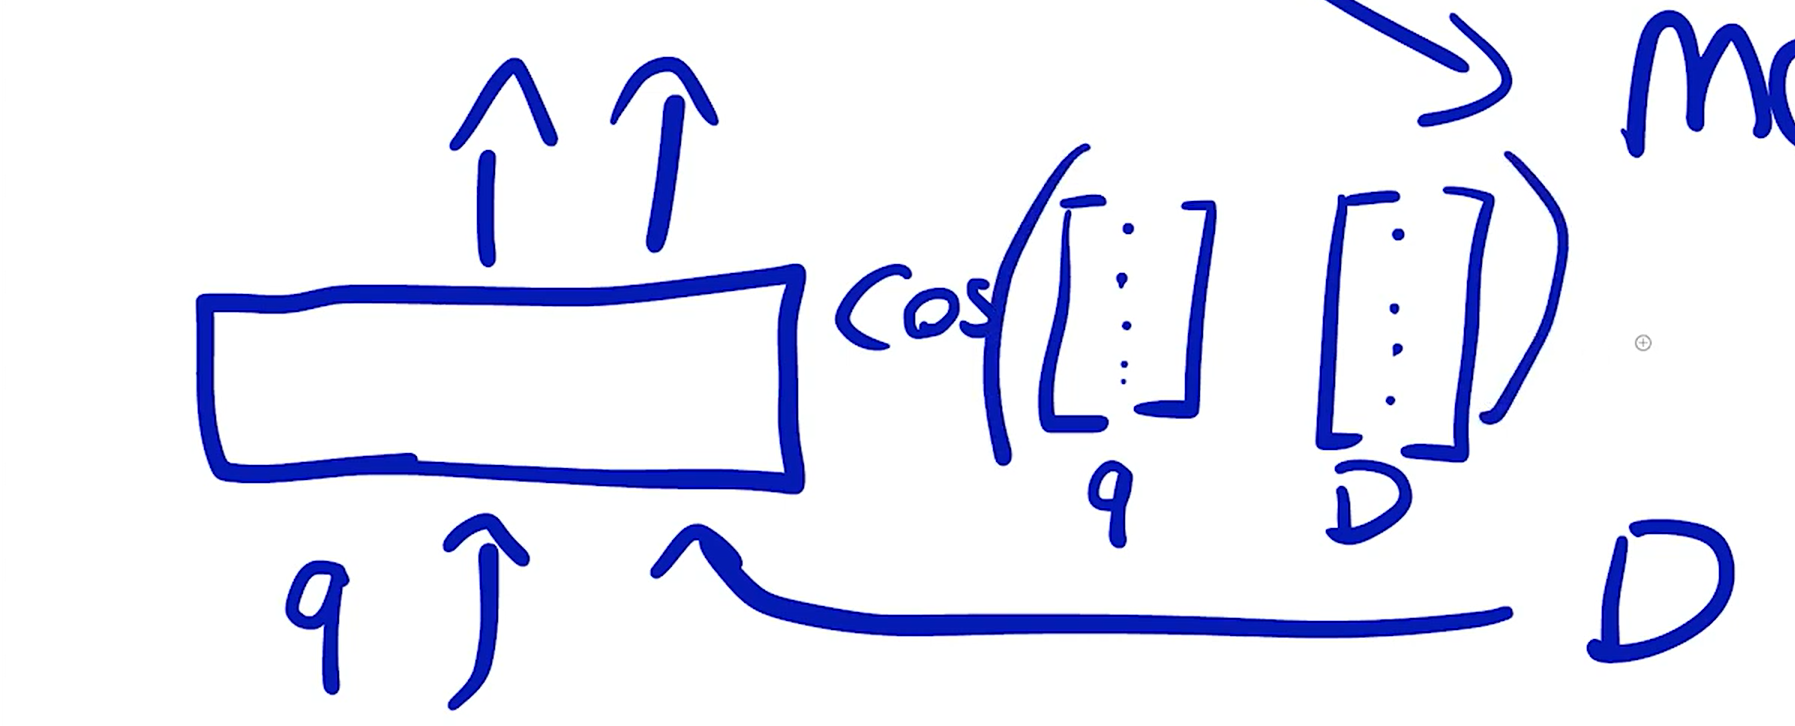

Through 12 (or so) encoder layers, BERT encodes a huge amount of information into a set of dense vectors. Each dense vector typically contains 768 values — and we usually have 512 of these vectors for each sentence encoded by BERT.

These vectors contain what we can view as numerical representations of language. We can also extract those vectors — from different layers if wanted — but typically from the final layer.

Now, with two correctly encoded dense vectors, we can use a similarity metric like Cosine similarity to calculate their semantic similarity. Vectors that are more aligned are more semantically alike, and vise-versa.

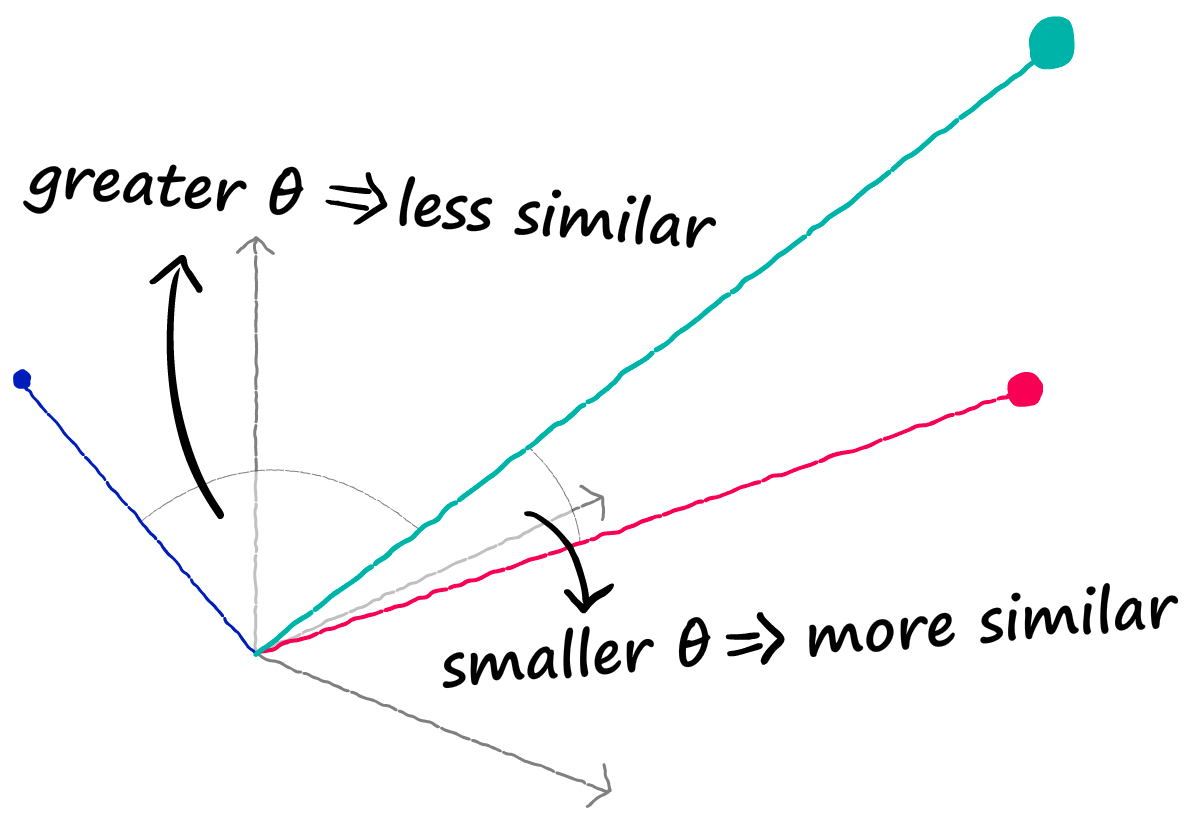

In [ ]:
a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"  # this is very similar to 'g'
c = "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e = "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"  # this is very similar to 'b'

Installing dependencies needed for this notebook

In [ ]:
!pip install -qU transformers sentence-transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

Initialize our HF transformer model and tokenizer - using a pretrained SBERT model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

Tokenize all of our sentences.

In [ ]:
tokens = tokenizer([a, b, c, d, e, f, g],
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')

In [ ]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens['input_ids'][0]

tensor([ 101, 6379, 2003, 1996, 2190, 2103, 1999, 1996, 3224,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Process our tokenized tensors through the model.

In [ ]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Here we can see the final embedding layer, *last_hidden_state*.

In [ ]:
embeddings = outputs.last_hidden_state
embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.1894, -0.3711,  0.3034,  ...,  0.1536,  0.3265,  0.1376],
        [-0.2496, -0.5227,  0.2341,  ...,  0.3419,  0.3164,  0.0256],
        [-0.3311, -0.4430,  0.3492,  ...,  0.3655,  0.2910,  0.0728]],
       grad_fn=<SelectBackward>)

In [ ]:
embeddings[0].shape

torch.Size([128, 768])

Here we have our vectors of length *768*, but we see that these are not *sentence vectors* because we have a vector representation for each token in our sequence (128 in total). We need to perform a mean pooling operation to create the sentence vector.

The first thing we do is multiply each value in our `embeddings` tensor by its respective `attention_mask` value. The `attention_mask` contains **1s** where we have 'real tokens' (eg not padding tokens), and 0s elsewhere - so this operation allows us to ignore non-real tokens.

In [ ]:
mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([7, 128, 768])

In [ ]:
mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now we have a masking array that has an equal shape to our output `embeddings` - we multiply those together to apply the masking operation on our outputs.

In [ ]:
masked_embeddings = embeddings * mask
masked_embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward>)

Sum the remaining embeddings along axis 1 to get a total value in each of our 768 values.

In [ ]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([7, 768])

Next, we count the number of values that should be given attention in each position of the tensor (+1 for real tokens, +0 for non-real).

In [ ]:
counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([7, 768])

Finally, we get our mean-pooled values as the `summed` embeddings divided by the number of values that should be given attention, `counted`.

In [ ]:
mean_pooled = summed / counted
mean_pooled.shape

torch.Size([7, 768])

Now we have our sentence vectors, we can calculate the cosine similarity between each.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [ ]:
# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [ ]:
scores

array([[ 1.00000012,  0.1869276 ,  0.2829769 ,  0.29628235,  0.2745102 ,
         0.10176259,  0.21696258],
       [ 0.1869276 ,  1.        ,  0.72058779,  0.51428956,  0.1174964 ,
         0.19306925,  0.66182363],
       [ 0.2829769 ,  0.72058779,  1.00000024,  0.4886443 ,  0.23568943,
         0.17157131,  0.55993092],
       [ 0.29628235,  0.51428956,  0.4886443 ,  0.99999988,  0.26985496,
         0.37889433,  0.52388811],
       [ 0.2745102 ,  0.1174964 ,  0.23568943,  0.26985496,  0.99999988,
         0.23422126, -0.01599787],
       [ 0.10176259,  0.19306925,  0.17157131,  0.37889433,  0.23422126,
         1.00000012,  0.22319663],
       [ 0.21696258,  0.66182363,  0.55993092,  0.52388811, -0.01599787,
         0.22319663,  1.        ]])

We can visualize these scores using `matplotlib`.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

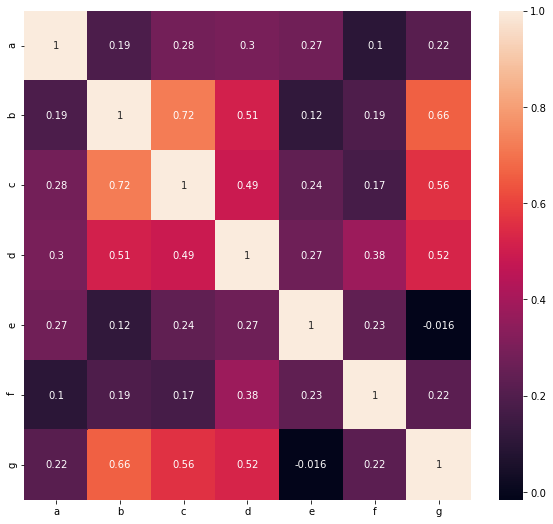

In [ ]:
plt.figure(figsize=(10,9))
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
sns.heatmap(scores, xticklabels=labels, yticklabels=labels, annot=True)

---

## Using sentence-transformers

The `sentence-transformers` library allows us to compress all of the above into just a few lines of code.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

We encode the sentences (producing our mean-pooled sentence embeddings) like so:

In [ ]:
sentence_embeddings = model.encode([a, b, c, d, e, f, g])

And calculate the cosine similarity just like before.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate similarities (will store in array)
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings
    )[0]

In [ ]:
scores

array([[ 1.        ,  0.18692753,  0.28297687,  0.29628229,  0.27451015,
         0.1017626 ,  0.21696255],
       [ 0.18692753,  0.99999988,  0.72058773,  0.5142895 ,  0.11749639,
         0.19306931,  0.66182363],
       [ 0.28297687,  0.72058773,  1.00000024,  0.48864418,  0.2356894 ,
         0.17157122,  0.55993092],
       [ 0.29628229,  0.5142895 ,  0.48864418,  0.99999976,  0.26985493,
         0.3788943 ,  0.52388811],
       [ 0.27451015,  0.11749639,  0.2356894 ,  0.26985493,  0.99999982,
         0.23422126, -0.01599786],
       [ 0.1017626 ,  0.19306931,  0.17157122,  0.3788943 ,  0.23422126,
         1.00000012,  0.22319666],
       [ 0.21696255,  0.66182363,  0.55993092,  0.52388811, -0.01599786,
         0.22319666,  1.        ]])